In [2]:
import fastf1
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Enable FastF1 cache
fastf1.Cache.enable_cache('../cache')

# Directory to save CSV files
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

In [ ]:

# Seasons to process
seasons = [2021, 2022, 2023, 2024, 2025]

for season in seasons:
    print(f"Processing season {season}...")
    season_data = []

    # Load the season schedule
    try:
        season_schedule = fastf1.get_event_schedule(season, force_ergast=True)
    except Exception as e:
        print(f"Failed to load schedule for season {season}: {e}")
        continue

    for _, event in season_schedule.iterrows():
        round_num = event['RoundNumber']
        race_name = event['EventName']

        print(f"  Processing Round {round_num} - {race_name}...")

        try:
            # Load qualifying session
            quali = fastf1.get_session(season, round_num, 'Q')
            quali.load()

            # Identify pole sitter
            pole_row = quali.results[quali.results['Position'] == 1]
            if pole_row.empty:
                print(f"    No pole sitter found for Round {round_num}")
                continue
            pole_driver = pole_row['Abbreviation'].values[0]

            # Load race session
            race = fastf1.get_session(season, round_num, 'R')
            race.load()

            # Identify race winner
            winner_row = race.results[race.results['Position'] == 1]
            if winner_row.empty:
                print(f"    No race winner found for Round {round_num}")
                continue
            race_winner = winner_row['Abbreviation'].values[0]

            # Pole finish position
            pole_finish_row = race.results[race.results['Abbreviation'] == pole_driver]
            pole_finish = pole_finish_row['Position'].values[0] if not pole_finish_row.empty else "DNF"

            # Lap 1 position (if available)
            lap1_position = None
            try:
                laps = race.laps
                pole_laps = laps[laps['Driver'] == pole_driver]
                lap1 = pole_laps[pole_laps['LapNumber'] == 1]['Position'].values
                if len(lap1) > 0:
                    lap1_position = lap1[0]
            except Exception as e:
                print(f"    Failed to get Lap 1 position for Round {round_num}: {e}")

            # Determine if the pole sitter won the race
            won_from_pole = pole_driver == race_winner

            # Append data
            season_data.append({
                'Season': season,
                'Round': round_num,
                'Circuit': race_name,
                'PoleDriver': pole_driver,
                'RaceWinner': race_winner,
                'PoleFinishPosition': pole_finish,
                'Lap1Position': lap1_position if lap1_position is not None else "DNF",
                'WonFromPole': won_from_pole
            })

        except Exception as e:
            print(f"    Failed to process Round {round_num}: {e}")
            continue

    # Convert to DataFrame and save
    df_season = pd.DataFrame(season_data)
    file_name = f"{output_dir}poles_{season}.csv"
    df_season.to_csv(file_name, index=False)
    print(f"✅ Saved season {season} data to {file_name}")

print("All seasons processed successfully.")


FastF1 version: 3.7.0
Setup complete!


✅ Loaded data: 114 races total (2021–2025)
✅ Drivers with ≥3 poles: ['BOT', 'HAM', 'LEC', 'NOR', 'PER', 'PIA', 'RUS', 'SAI', 'VER']

=== Pole Conversion Summary (≥3 poles, 2021–2025) ===
  PoleDriver  Poles  ConversionRate
8        VER     48              77
5        PIA      6              67
6        RUS      7              57
3        NOR     16              50
1        HAM      6              50
7        SAI      6              50
4        PER      3              33
0        BOT      4              25
2        LEC     18              17


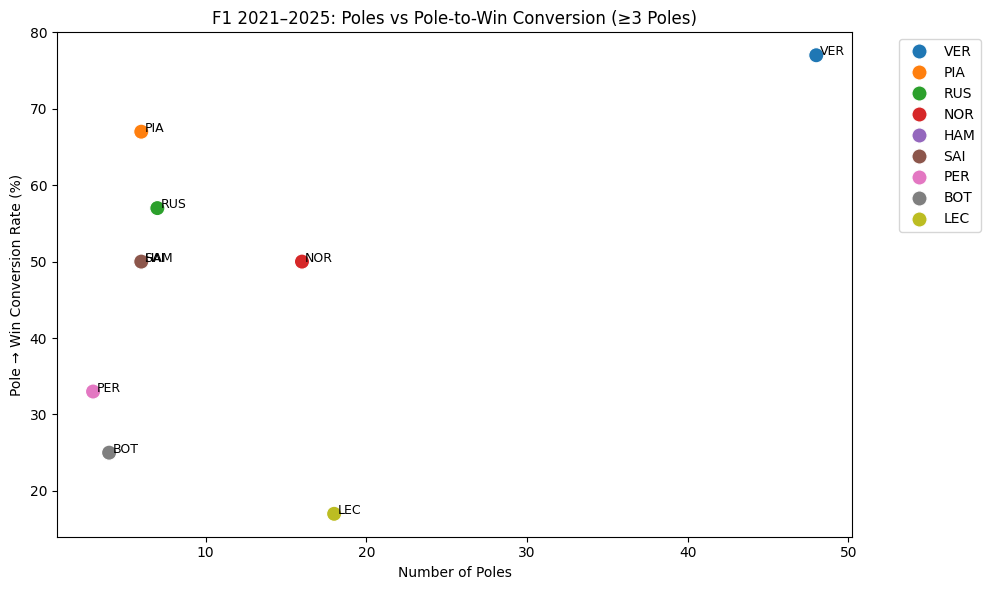

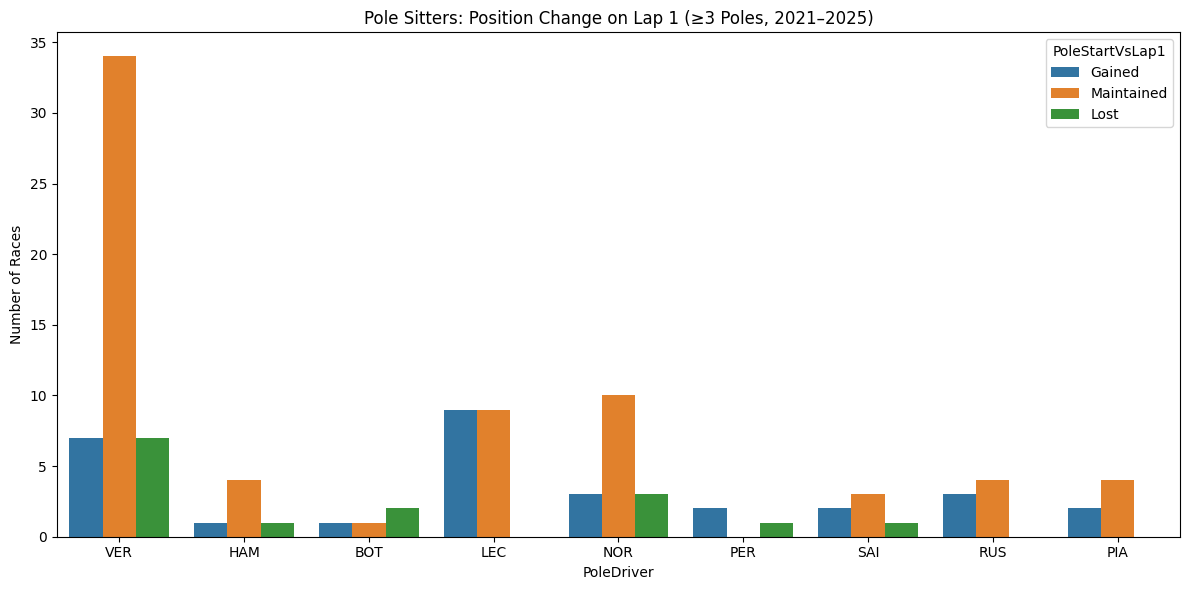

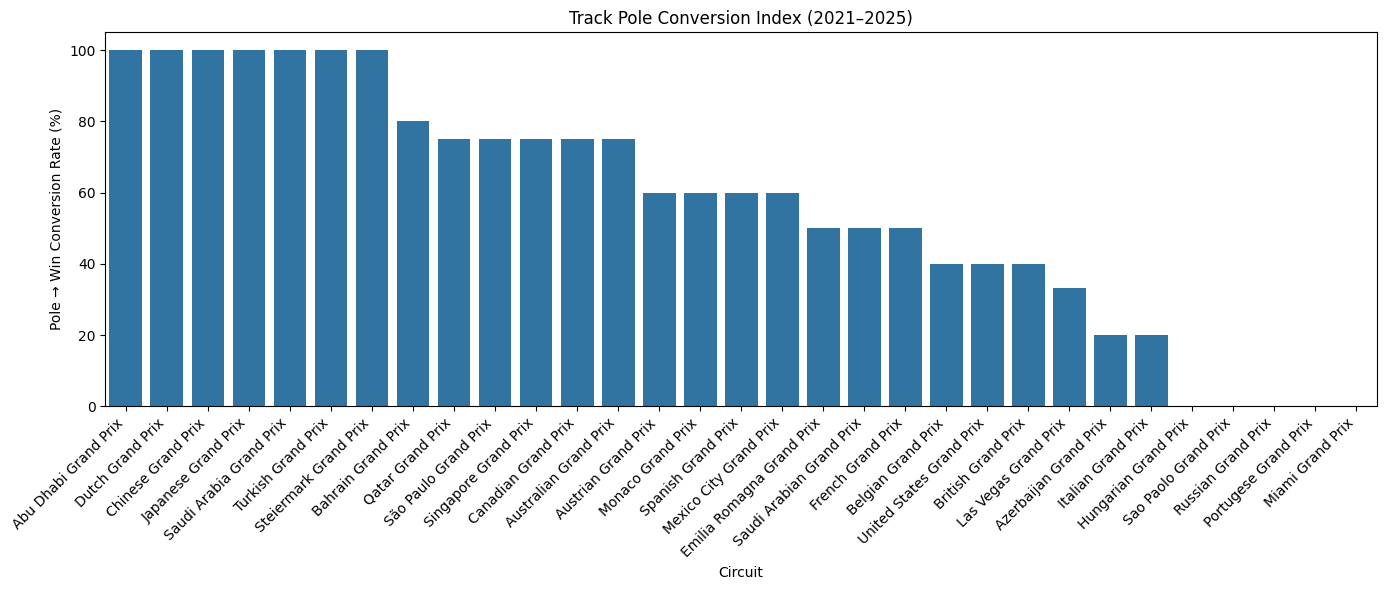

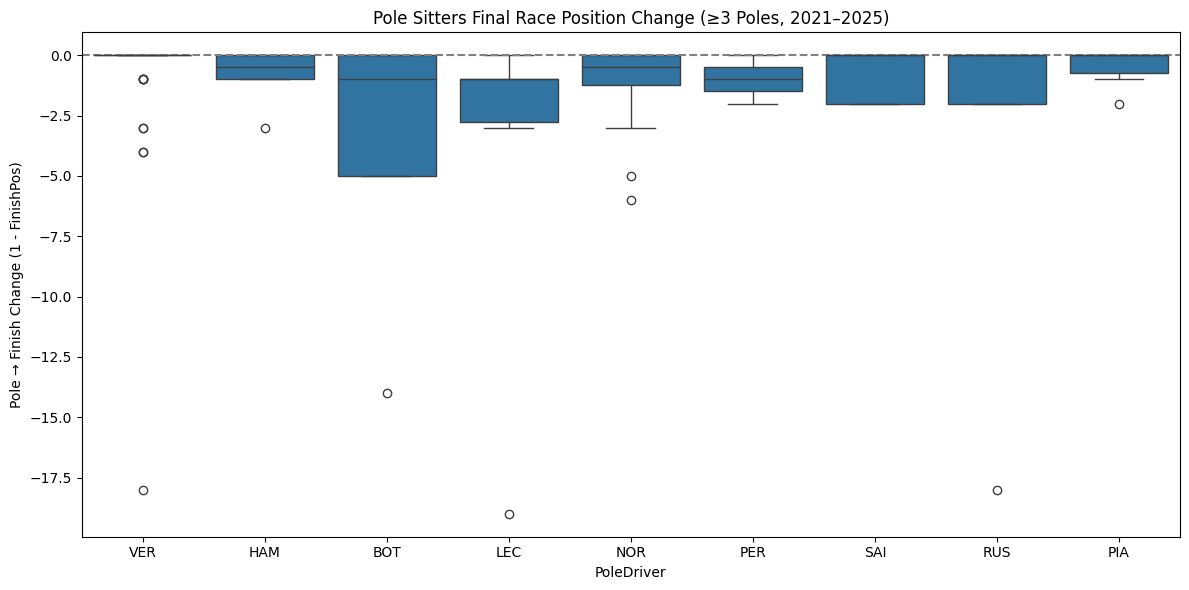


✅ Analysis Complete: Drivers with ≥3 poles (2021–2025)
✅ All graphs saved in 'graphs/' folder


In [6]:


# --------------------------
# 1️⃣ Load and combine data
# --------------------------
df_2021 = pd.read_csv('../data/processed/poles_2021.csv')
df_2022 = pd.read_csv('../data/processed/poles_2022.csv')
df_2023 = pd.read_csv('../data/processed/poles_2023.csv')
df_2024 = pd.read_csv('../data/processed/poles_2024.csv')
df_2025 = pd.read_csv('../data/processed/poles_2025.csv')

# Ensure consistent data types
for df in [df_2021, df_2022, df_2023, df_2024, df_2025]:
    df['PoleFinishPosition'] = pd.to_numeric(df['PoleFinishPosition'], errors='coerce')
    df['Lap1Position'] = pd.to_numeric(df['Lap1Position'], errors='coerce')
    df['WonFromPole'] = df['WonFromPole'].astype(bool)

# Combine all seasons
df_all = pd.concat([df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)
print(f"✅ Loaded data: {df_all.shape[0]} races total (2021–2025)")

# --------------------------
# 2️⃣ Lap1Change (positive = gained positions, negative = lost)
# --------------------------
df_all['Lap1Change'] = df_all['PoleFinishPosition'] - df_all['Lap1Position']

# --------------------------
# 3️⃣ PoleStartVsLap1: categorical
# --------------------------
df_all['PoleStartVsLap1'] = df_all['Lap1Change'].apply(
    lambda x: 'Gained' if x > 0 else ('Lost' if x < 0 else 'Maintained')
)

# --------------------------
# 4️⃣ PoleToFinishChange: difference between PoleFinishPosition and starting Pole (always 1)
# --------------------------
df_all['PoleToFinishChange'] = 1 - df_all['PoleFinishPosition']

# --------------------------
# 5️⃣ Driver filter: ≥3 poles
# --------------------------
driver_counts = df_all.groupby('PoleDriver').size()
drivers_3plus = driver_counts[driver_counts >= 3].index
df_filtered = df_all[df_all['PoleDriver'].isin(drivers_3plus)]
print(f"✅ Drivers with ≥3 poles: {list(drivers_3plus)}")

# --------------------------
# 6️⃣ Pole Conversion Rates (≥3 poles)
# --------------------------
pole_counts = df_filtered.groupby('PoleDriver').size().reset_index(name='Poles')
pole_conversion = df_filtered.groupby('PoleDriver')['WonFromPole'].mean().reset_index()
pole_conversion = pole_conversion.merge(pole_counts, on='PoleDriver')
pole_conversion['ConversionRate'] = (pole_conversion['WonFromPole'] * 100).round(0).astype(int)
pole_conversion = pole_conversion.sort_values('ConversionRate', ascending=False)

# Print summary table before plotting
print("\n=== Pole Conversion Summary (≥3 poles, 2021–2025) ===")
print(pole_conversion[['PoleDriver', 'Poles', 'ConversionRate']])

# Scatterplot: Poles vs Conversion
plt.figure(figsize=(10,6))
sns.scatterplot(data=pole_conversion, x='Poles', y='ConversionRate', hue='PoleDriver', s=120)
for _, row in pole_conversion.iterrows():
    plt.text(row['Poles'] + 0.2, row['ConversionRate'], row['PoleDriver'], fontsize=9)
plt.xlabel("Number of Poles")
plt.ylabel("Pole → Win Conversion Rate (%)")
plt.title("F1 2021–2025: Poles vs Pole-to-Win Conversion (≥3 Poles)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../graphs/poles_vs_conversion.png")
plt.show()

# --------------------------
# 7️⃣ Lap 1 Position Change Analysis (categorical comparison)
# --------------------------
plt.figure(figsize=(12,6))
sns.countplot(x='PoleDriver', hue='PoleStartVsLap1', data=df_filtered)
plt.ylabel("Number of Races")
plt.title("Pole Sitters: Position Change on Lap 1 (≥3 Poles, 2021–2025)")
plt.tight_layout()
plt.savefig("../graphs/pole_start_vs_lap1.png")
plt.show()

# --------------------------
# 8️⃣ Track Pole Conversion Index (all drivers)
# --------------------------
track_pci = df_all.groupby('Circuit')['WonFromPole'].mean().reset_index()
track_pci['PCI'] = (track_pci['WonFromPole'] * 100).round(1)
track_pci = track_pci.sort_values('PCI', ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x='Circuit', y='PCI', data=track_pci)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pole → Win Conversion Rate (%)")
plt.title("Track Pole Conversion Index (2021–2025)")
plt.tight_layout()
plt.savefig("../graphs/track_pci.png")
plt.show()

# --------------------------
# 9️⃣ Pole to Finish Change Analysis
# --------------------------
plt.figure(figsize=(12,6))
sns.boxplot(x='PoleDriver', y='PoleToFinishChange', data=df_filtered)
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel("Pole → Finish Change (1 - FinishPos)")
plt.title("Pole Sitters Final Race Position Change (≥3 Poles, 2021–2025)")
plt.tight_layout()
plt.savefig("../graphs/pole_to_finish_change.png")
plt.show()

# --------------------------
# 🔹 Lap1 stats per driver (for CSV output)
# --------------------------
lap1_stats = df_filtered.groupby('PoleDriver').agg(
    Poles=('PoleFinishPosition', 'count'),
    AvgLap1Change=('Lap1Change', 'mean')
).reset_index()
lap1_stats['AvgLap1Change'] = lap1_stats['AvgLap1Change'].round(1)
lap1_stats = lap1_stats.sort_values('AvgLap1Change')

# --------------------------
# 🔹 Save Final Outputs
# --------------------------
df_filtered.to_csv('poles_2021_2025_3plus_full.csv', index=False)
pole_conversion.to_csv('pole_conversion_driver_2021_2025_3plus.csv', index=False)
lap1_stats.to_csv('lap1_stats_driver_2021_2025_3plus.csv', index=False)
track_pci.to_csv('track_pci_2021_2025.csv', index=False)

print("\n✅ Analysis Complete: Drivers with ≥3 poles (2021–2025)")
print("✅ All graphs saved in 'graphs/' folder")


In [29]:
import fastf1

race = fastf1.get_session(2022, 1, 'Race')
race.load()
results = race.results[['Driver', 'Constructor', 'Position', 'Points']]


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

KeyError: "['Driver', 'Constructor'] not in index"